# **Pure $\lambda$-Calculus**

[The deatailed script](https://www.mathcha.io/editor/Pvvz5UZ1t7ktL6sZJYp19sZnX9vVserJMEKhJvvMx7)

## **Variables**

The code below models variables.

Using the `natgen()` generator in this code ensures that a fresh variable is returned in response to each constructor call.

## Import dependencies

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append('../')
from calculus.term import *
from calculus.strategy import *
from calculus.generation import gen_filtered_lambda_terms

from calculus_utils.drawing import *
from calculus_utils.algorithms import *

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
UPLIMIT = 60
DOWNLIMIT = 50
LAMBDA_TERM_COUNT = 100
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms(
    count_terms=LAMBDA_TERM_COUNT, down_vertices_limit=DOWNLIMIT,
    up_vertices_limit=UPLIMIT)

countVertices = list(map(lambda term: term.verticesNumber, terms))
countRedexes = list(map(lambda term: len(term.redexes), terms))

print(f"number of lambda terms {len(terms)}")
print("number of vertices= {}".format(countVertices))
print("number of redexes= {}".format(countRedexes))

print("number of steps to normalize using LO strategy= {}".format(stepsLO))
print(f'number of terms with normal form {len(terms)}')

print("number of steps to normalize using LO strategy= {}".format(stepsLO))

stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in terms]
print("number of steps to normalize using RI strategy= {}".format(stepsRI))

stepsRand = [sum([term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT)]) / RANDOM_AVERAGE_COUNT for
             term in terms]
print("number of steps to normalize using Random strategy= {}".format(stepsRand))

Generated terms: 240
LO strategy applying
Remove unormalized terms
Left 100 normalizeble terms
number of lambda terms 100
number of vertices= [59, 53, 55, 53, 59, 54, 59, 59, 51, 55, 53, 55, 51, 51, 51, 59, 55, 54, 56, 51, 59, 55, 54, 57, 54, 53, 53, 53, 51, 56, 58, 58, 55, 52, 59, 52, 51, 56, 59, 51, 53, 57, 54, 54, 58, 53, 56, 52, 53, 57, 51, 56, 56, 54, 51, 55, 54, 56, 54, 53, 54, 51, 58, 52, 54, 55, 52, 59, 55, 55, 51, 59, 53, 52, 51, 53, 53, 58, 58, 55, 55, 52, 53, 55, 52, 56, 53, 59, 57, 51, 56, 55, 56, 58, 51, 57, 58, 57, 56, 59]
number of redexes= [5, 6, 6, 7, 7, 5, 8, 11, 6, 8, 7, 4, 6, 5, 6, 5, 5, 5, 6, 8, 7, 8, 8, 5, 5, 5, 6, 5, 2, 2, 7, 4, 8, 8, 9, 5, 4, 8, 6, 5, 8, 7, 4, 4, 4, 7, 10, 2, 6, 4, 3, 4, 4, 7, 7, 7, 2, 4, 6, 7, 8, 6, 4, 3, 6, 6, 5, 2, 8, 5, 5, 8, 7, 6, 9, 4, 4, 3, 4, 7, 6, 3, 5, 9, 4, 3, 6, 7, 6, 5, 3, 3, 7, 3, 4, 7, 2, 7, 4, 4]
number of steps to normalize using LO strategy= [5, 13, 6, 8, 12, 5, 5, 5, 11, 15, 2, 2, 5, 165, 7, 6, 7, 5, 8, 8, 10, 4, 30, 2, 6, 9, 

In [3]:
print('max cound LO: {}'.format(max(stepsLO)))
print('max cound RI: {}'.format(max(stepsRI)))
print('max cound Rand: {}'.format(max(stepsRand)))

max cound LO: 165
max cound RI: inf
max cound Rand: inf


In [4]:
max_count_steps_rlenv = 165
strategies_env = [LeftmostOutermostStrategy(),
                  RightmostInnermostStrategy()]

explore_ep = 10  # total 10 * 2 (strat) = 20
epsilon = .1

In [5]:
lambda_env = LambdaEnv(strategies=strategies_env,
                       lambda_terms=terms,
                       max_step_term=max_count_steps_rlenv,
                       count_terms=LAMBDA_TERM_COUNT)

lambda_env, rewards_greedy = run_greedy_policy(lambda_env,
                                               exploration=explore_ep,
                                               max_term_reward=max_count_steps_rlenv)

In [6]:
lambda_env = LambdaEnv(strategies=strategies_env,
                       lambda_terms=terms,
                       max_step_term=max_count_steps_rlenv,
                       count_terms=LAMBDA_TERM_COUNT)

lambda_env, rewards_e_greedy = run_e_greedy_policy(lambda_env,
                                                   exploration=explore_ep,
                                                   max_term_reward=max_count_steps_rlenv,
                                                   epsilon=epsilon)

In [7]:
rewards_greedy = [max_count_steps_rlenv - rew for rew in rewards_greedy]
rewards_e_greedy = [max_count_steps_rlenv - rew for rew in rewards_e_greedy]

In [8]:
print("number of steps to normalize using Greedy policy = {}".format(rewards_greedy))
print("number of steps to normalize using e-Greedy policy = {}".format(rewards_e_greedy))

number of steps to normalize using Greedy policy = [20, 165, 9, 165, 165, 52, 2, 165, 11, 165, 6, 7, 22, 10, 165, 7, 8, 7, 17, 13, 4, 22, 3, 3, 7, 80, 4, 5, 11, 165, 4, 19, 7, 7, 14, 2, 62, 2, 6, 8, 165, 9, 165, 14, 16, 11, 132, 5, 5, 70, 8, 10, 165, 3, 11, 7, 15, 4, 8, 12, 13, 16, 165, 8, 5, 7, 9, 12, 3, 17, 16, 11, 13, 14, 6, 5, 3, 2, 8, 6, 2, 12, 6, 4, 3, 165, 5, 19, 3, 2, 7, 5, 6, 8, 165, 15, 165, 2, 8, 0]
number of steps to normalize using e-Greedy policy = [2, 4, 165, 10, 10, 6, 7, 10, 5, 8, 8, 49, 25, 7, 5, 4, 7, 10, 5, 16, 4, 9, 14, 6, 9, 165, 13, 17, 16, 23, 13, 6, 165, 5, 165, 19, 5, 16, 165, 11, 13, 9, 6, 10, 6, 13, 5, 3, 165, 5, 3, 5, 6, 12, 20, 9, 4, 11, 8, 9, 9, 13, 6, 6, 9, 5, 19, 165, 21, 165, 22, 3, 15, 165, 27, 17, 7, 15, 22, 20, 11, 15, 11, 16, 4, 165, 11, 14, 3, 14, 51, 8, 7, 14, 165, 8, 165, 10, 7, 0]


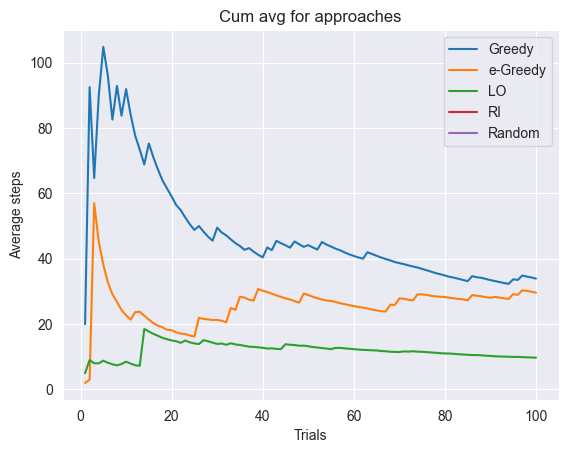

In [9]:
comp_data = {"Greedy": (rewards_greedy, "-"),
             "e-Greedy": (rewards_e_greedy, "-"),
             "LO": (stepsLO, "-"),
             "RI": (stepsRI, "-"),
             "Random": (stepsRand, "-")}

draw_cumulative_avg_comparison(comp_data)

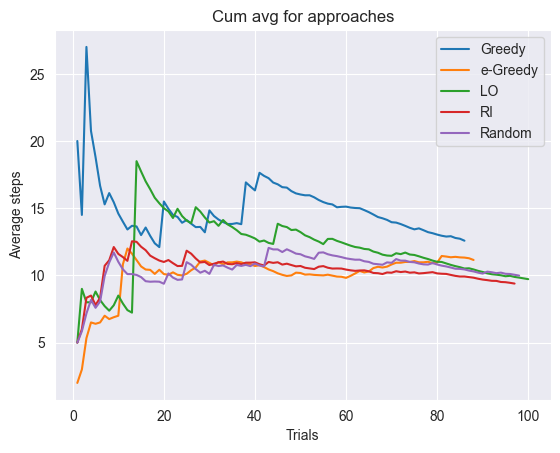

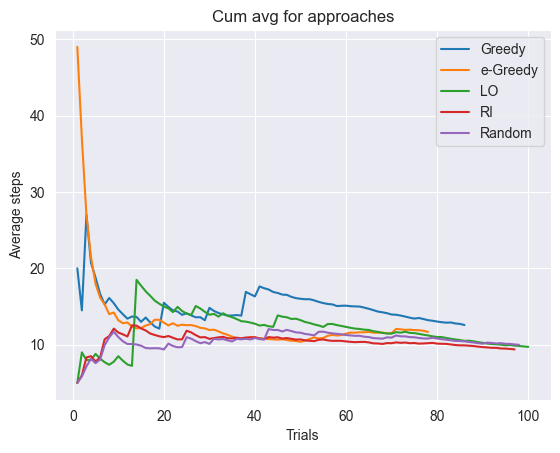

In [10]:
rewards_greedy_ = []
rewards_e_greedy_ = []
stepsLO_ = []
stepsRI_ = []
stepsRand_ = []

for x in rewards_greedy:
    if x != max_count_steps_rlenv:
        rewards_greedy_.append(x)

for x in rewards_e_greedy:
    if x != max_count_steps_rlenv:
        rewards_e_greedy_.append(x)

for x in stepsLO:
    if x != np.inf:
        stepsLO_.append(x)

for x in stepsRI:
    if x != np.inf:
        stepsRI_.append(x)

for x in stepsRand:
    if x != np.inf:
        stepsRand_.append(x)

comp_data = {"Greedy": (rewards_greedy_, "-"),
             "e-Greedy": (rewards_e_greedy_, "-"),
             "LO": (stepsLO_, "-"),
             "RI": (stepsRI_, "-"),
             "Random": (stepsRand_, "-")}

draw_cumulative_avg_comparison(comp_data)

comp_data = {"Greedy": (rewards_greedy_, "-"),
             "e-Greedy": (rewards_e_greedy_[10:], "-"),
             "LO": (stepsLO_, "-"),
             "RI": (stepsRI_, "-"),
             "Random": (stepsRand_, "-")}

draw_cumulative_avg_comparison(comp_data)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 32.38it/s]


number of not normalized terms: 0
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.007026  1505.351641 -796.108430     inf      0.083696   
chi2             0.012590  1619.413526 -745.949871     inf      0.142773   
gamma            0.012590  1619.415077 -745.949452     inf      0.142771   
rayleigh         0.022577  2030.107492 -700.174500     inf      0.305675   
exponpow         0.025336  1427.276952 -685.804745     inf      0.229646   

             ks_pvalue  
lognorm   5.549147e-01  
chi2      5.417769e-02  
gamma     5.418182e-02  
rayleigh  1.249638e-07  
exponpow  1.807547e-04  
{'lognorm': {'s': 0.8308725030740407, 'loc': -0.6251780359162262, 'scale': 8.666610588792533}}
Norm distribution: (12.581395348837209, 18.563195091537715)


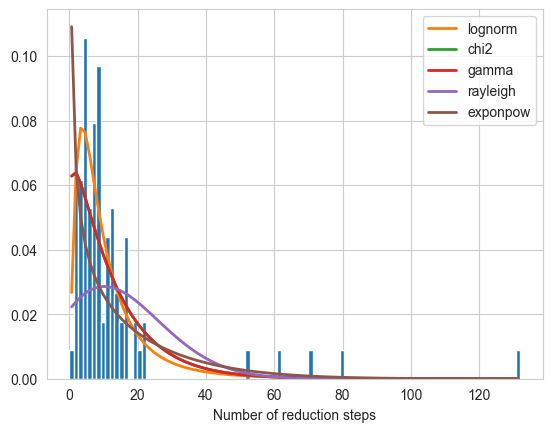

ValueError: autodetected range of [-inf, 4.882801922586371] is not finite

In [31]:
draw_hist(rewards_greedy_)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 24.16it/s]


number of not normalized terms: 0
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.013358  1294.907801 -878.266061     inf      0.163250   
chi2             0.019187  1225.116326 -842.055151     inf      0.276513   
gamma            0.021192  1192.024388 -832.113057     inf      0.277661   
powerlaw         0.024865  1099.679440 -816.130303     inf      0.371741   
exponpow         0.025377  1241.450247 -814.093698     inf      0.283573   

             ks_pvalue  
lognorm   8.509487e-03  
chi2      2.990065e-07  
gamma     2.619404e-07  
powerlaw  6.545077e-13  
exponpow  1.312396e-07  
{'lognorm': {'s': 1.1408920048153177, 'loc': -0.32539321843476143, 'scale': 13.090154793407624}}
Norm distribution: (29.61, 50.5875271188462)


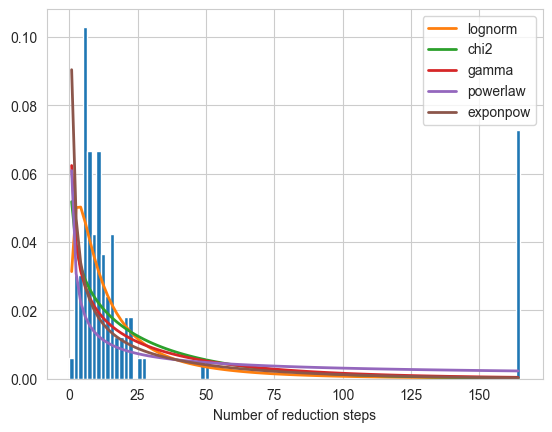

ValueError: autodetected range of [-inf, 5.10594547390058] is not finite

In [27]:
draw_hist(rewards_e_greedy)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 28.16it/s]


number of not normalized terms: 0
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.004190  1714.110256 -994.204673     inf      0.091511   
chi2             0.015141  1315.871158 -865.739685     inf      0.316538   
exponpow         0.019078  1208.014863 -842.624682     inf      0.387276   
powerlaw         0.024505  1123.477335 -817.587581     inf      0.460251   
rayleigh         0.028020  3022.222552 -808.788764     inf      0.355146   

             ks_pvalue  
lognorm   3.508093e-01  
chi2      2.085579e-09  
exponpow  5.188007e-14  
powerlaw  6.677097e-20  
rayleigh  8.616617e-12  
{'lognorm': {'s': 1.02418336837004, 'loc': 0.5299797675969962, 'scale': 4.904556118750751}}
Norm distribution: (9.72, 18.608105760662475)


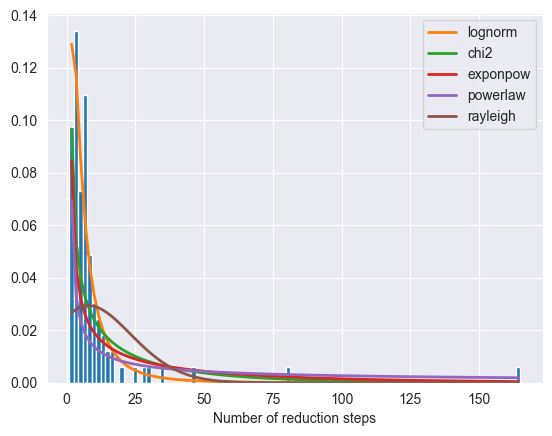

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 33.02it/s]

Log Norm distribution params: (1.742078185625121, 0.8936733024523632); expected value = 8.511380679060007


In [13]:
draw_hist(stepsLO)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 26.31it/s]


number of not normalized terms: 3
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.372785   969.251714 -525.738042     inf      0.070069   
gamma            0.373383   982.897047 -525.582515     inf      0.081941   
rayleigh         0.380636  1145.622424 -528.290986     inf      0.145373   
norm             0.392431  1235.045827 -525.330827     inf      0.145254   
exponpow         0.396183   985.037770 -519.833036     inf      0.144888   

          ks_pvalue  
lognorm    0.700918  
gamma      0.506645  
rayleigh   0.029773  
norm       0.029977  
exponpow   0.030614  
{'lognorm': {'s': 0.5514189183540992, 'loc': -0.28733186671781097, 'scale': 8.309813952573785}}
Norm distribution: (9.391752577319588, 5.84958664683087)


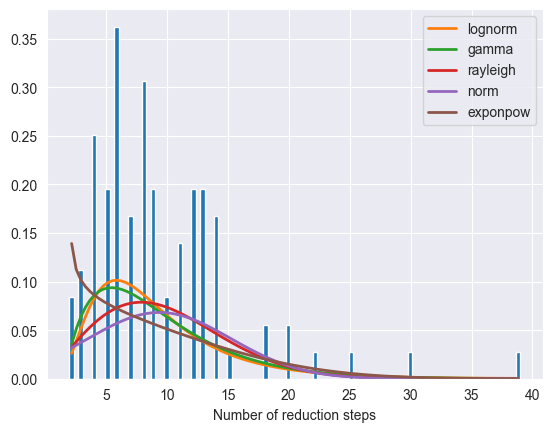

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 27.11it/s]

Log Norm distribution params: (2.076029603804448, 0.5749653757159096); expected value = 9.405759321576774


In [14]:
draw_hist(stepsRI)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 27.02it/s]


number of not normalized terms: 2
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
exponpow         0.046086  1203.631336 -737.142863     inf      0.158551   
rayleigh         0.051818  1711.636874 -730.238101     inf      0.254192   
norm             0.061994  1773.966218 -712.666503     inf      0.237886   
powerlaw         0.063682   935.384000 -705.450093     inf      0.284017   
lognorm          0.082861  1319.465543 -679.649319     inf      0.292941   

             ks_pvalue  
exponpow  1.281720e-02  
rayleigh  4.540728e-06  
norm      2.305674e-05  
powerlaw  1.729864e-07  
lognorm   6.035185e-08  
{'exponpow': {'b': 0.555073859847298, 'loc': 1.9999999999999998, 'scale': 15.641105418702079}}
Norm distribution: (9.98469387755102, 9.620769433788848)


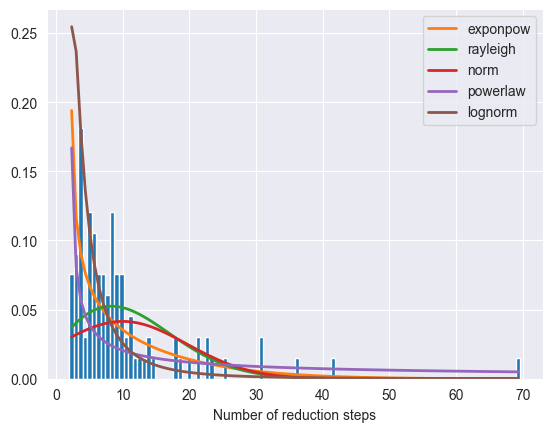

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 44.71it/s]

Log Norm distribution params: (2.018109263031849, 0.7073916442211445); expected value = 9.663063516766163


In [15]:
draw_hist(stepsRand)

Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 42.02it/s]


expected number of steps to normalize using Mixed strategy= 9.312327812838443


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.86it/s]


expected number of steps to normalize using Mixed strategy= 10.054222211989075


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.70it/s]


expected number of steps to normalize using Mixed strategy= 8.74249102967093


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.61it/s]


expected number of steps to normalize using Mixed strategy= 10.3024205721245


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 48.12it/s]


expected number of steps to normalize using Mixed strategy= 9.792596934289701


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.91it/s]


expected number of steps to normalize using Mixed strategy= 9.030320785442681


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.77it/s]


expected number of steps to normalize using Mixed strategy= 9.290249395538424


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.62it/s]


expected number of steps to normalize using Mixed strategy= 9.387572919357291


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.47it/s]


expected number of steps to normalize using Mixed strategy= 11.075344252942307


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.26it/s]


expected number of steps to normalize using Mixed strategy= 9.121083202403906


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]


expected number of steps to normalize using Mixed strategy= 9.83199976055422


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 48.38it/s]


expected number of steps to normalize using Mixed strategy= 9.81642973415407


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.97it/s]


expected number of steps to normalize using Mixed strategy= 8.63546588726848


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 41.66it/s]


expected number of steps to normalize using Mixed strategy= 8.867301972592513


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 42.24it/s]


expected number of steps to normalize using Mixed strategy= 9.947447424327832


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.56it/s]


expected number of steps to normalize using Mixed strategy= 8.967031174684843


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 36.73it/s]


expected number of steps to normalize using Mixed strategy= 8.75309012606416


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.62it/s]


expected number of steps to normalize using Mixed strategy= 10.339465810689292


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.58it/s]


expected number of steps to normalize using Mixed strategy= 9.74943351758531


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.97it/s]


expected number of steps to normalize using Mixed strategy= 8.809031668967659
gen	nevals	min    	avg    
0  	20    	8.63547	9.49127


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 40.57it/s]


expected number of steps to normalize using Mixed strategy= 8.622756896420366


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.61it/s]


expected number of steps to normalize using Mixed strategy= 9.951838271902236


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 49.17it/s]


expected number of steps to normalize using Mixed strategy= 9.898922205392699


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 48.38it/s]


expected number of steps to normalize using Mixed strategy= 9.797524505022531


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.86it/s]


expected number of steps to normalize using Mixed strategy= 8.782307040596601


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.33it/s]


expected number of steps to normalize using Mixed strategy= 9.222475240006402


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.57it/s]


expected number of steps to normalize using Mixed strategy= 8.826669149925037


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.33it/s]


expected number of steps to normalize using Mixed strategy= 8.816675973757972


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.48it/s]


expected number of steps to normalize using Mixed strategy= 9.676258429700708


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 49.44it/s]


expected number of steps to normalize using Mixed strategy= 9.799184246507464


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.68it/s]


expected number of steps to normalize using Mixed strategy= 9.05795918765324


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 34.61it/s]


expected number of steps to normalize using Mixed strategy= 8.775871889419298


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.89it/s]


expected number of steps to normalize using Mixed strategy= 10.314249163061


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.68it/s]


expected number of steps to normalize using Mixed strategy= 9.18795399606123
1  	14    	8.62276	12.0687


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.45it/s]


expected number of steps to normalize using Mixed strategy= 8.678473023521086


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.14it/s]


expected number of steps to normalize using Mixed strategy= 10.203041813959329


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


expected number of steps to normalize using Mixed strategy= 8.635766959937543


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.95it/s]


expected number of steps to normalize using Mixed strategy= 8.646213013984633


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]


expected number of steps to normalize using Mixed strategy= 9.832898841545031


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.50it/s]


expected number of steps to normalize using Mixed strategy= 8.735214246034591


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.26it/s]


expected number of steps to normalize using Mixed strategy= 8.664539594558335


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.29it/s]


expected number of steps to normalize using Mixed strategy= 9.813121380867454


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 41.66it/s]


expected number of steps to normalize using Mixed strategy= 8.782845206569188


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 34.48it/s]


expected number of steps to normalize using Mixed strategy= 8.642310142454095


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.84it/s]


expected number of steps to normalize using Mixed strategy= 8.748550738867689


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 42.05it/s]


expected number of steps to normalize using Mixed strategy= 8.842025914019843


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 42.44it/s]


expected number of steps to normalize using Mixed strategy= 8.787202835663011


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.61it/s]


expected number of steps to normalize using Mixed strategy= 9.74263143509067
2  	14    	8.63547	9.02776


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 40.35it/s]


expected number of steps to normalize using Mixed strategy= 8.729115488759758


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 49.17it/s]


expected number of steps to normalize using Mixed strategy= 9.771597313677841


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]


expected number of steps to normalize using Mixed strategy= 8.658912255059404


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.68it/s]


expected number of steps to normalize using Mixed strategy= 9.245010549272775


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.89it/s]


expected number of steps to normalize using Mixed strategy= 8.75409856818604


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.47it/s]


expected number of steps to normalize using Mixed strategy= 8.76039741496897


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 32.96it/s]


expected number of steps to normalize using Mixed strategy= 8.725929286797685


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 41.85it/s]


expected number of steps to normalize using Mixed strategy= 9.606919828363912


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 42.89it/s]


expected number of steps to normalize using Mixed strategy= 8.839000263063758


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 30.92it/s]


expected number of steps to normalize using Mixed strategy= 8.735836113882883


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 32.13it/s]


expected number of steps to normalize using Mixed strategy= 8.810335644370097


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.54it/s]


expected number of steps to normalize using Mixed strategy= 9.65761176620343


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.45it/s]


expected number of steps to normalize using Mixed strategy= 8.641314482905496


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.29it/s]


expected number of steps to normalize using Mixed strategy= 8.595176268247148


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 34.08it/s]


expected number of steps to normalize using Mixed strategy= 8.748931659261332


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.90it/s]


expected number of steps to normalize using Mixed strategy= 8.70673463152278
3  	16    	8.59518	11.5729


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.97it/s]


expected number of steps to normalize using Mixed strategy= 8.85585550440822


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]


expected number of steps to normalize using Mixed strategy= 8.65629232906798


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.12it/s]


expected number of steps to normalize using Mixed strategy= 8.672914690346994


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.62it/s]


expected number of steps to normalize using Mixed strategy= 9.699557944719816


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.95it/s]


expected number of steps to normalize using Mixed strategy= 8.635737795964635


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.97it/s]


expected number of steps to normalize using Mixed strategy= 8.7367043835647


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 40.35it/s]


expected number of steps to normalize using Mixed strategy= 8.67962606656018


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.11it/s]


expected number of steps to normalize using Mixed strategy= 8.60267435399931


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 30.61it/s]


expected number of steps to normalize using Mixed strategy= 8.756876529544877


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.34it/s]


expected number of steps to normalize using Mixed strategy= 8.856056522903197


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.81it/s]


expected number of steps to normalize using Mixed strategy= 8.661847281352536


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.46it/s]


expected number of steps to normalize using Mixed strategy= 8.734334970854581


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.45it/s]


expected number of steps to normalize using Mixed strategy= 8.630226389059874


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.62it/s]


expected number of steps to normalize using Mixed strategy= 8.70446378281161
4  	14    	8.60267	8.8615 


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.11it/s]


expected number of steps to normalize using Mixed strategy= 8.720983393496653


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.29it/s]


expected number of steps to normalize using Mixed strategy= 8.717580741502843


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 46.14it/s]


expected number of steps to normalize using Mixed strategy= 9.720782082019356


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.65it/s]


expected number of steps to normalize using Mixed strategy= 8.712099784652933


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.13it/s]


expected number of steps to normalize using Mixed strategy= 8.632040220301073


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.44it/s]


expected number of steps to normalize using Mixed strategy= 8.700940259344547


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.18it/s]


expected number of steps to normalize using Mixed strategy= 8.623767313102828


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.28it/s]


expected number of steps to normalize using Mixed strategy= 9.776041188219324


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.11it/s]


expected number of steps to normalize using Mixed strategy= 8.657856121273978


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 34.61it/s]


expected number of steps to normalize using Mixed strategy= 8.640392817260189


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.34it/s]


expected number of steps to normalize using Mixed strategy= 8.77918079658932


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.33it/s]


expected number of steps to normalize using Mixed strategy= 8.616142879579979


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 32.96it/s]


expected number of steps to normalize using Mixed strategy= 8.67553845780382


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 34.34it/s]


expected number of steps to normalize using Mixed strategy= 8.856595770790067


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.70it/s]


expected number of steps to normalize using Mixed strategy= 8.635311756098734
5  	15    	8.60267	9.78568


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.77it/s]


expected number of steps to normalize using Mixed strategy= 8.642964852867594


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.46it/s]


expected number of steps to normalize using Mixed strategy= 8.643305360857712


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.56it/s]


expected number of steps to normalize using Mixed strategy= 8.637495727315196


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.45it/s]


expected number of steps to normalize using Mixed strategy= 8.645746634425235


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.77it/s]


expected number of steps to normalize using Mixed strategy= 9.695273945762743


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


expected number of steps to normalize using Mixed strategy= 8.632997579456246


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.99it/s]


expected number of steps to normalize using Mixed strategy= 8.679418767259902


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.12it/s]


expected number of steps to normalize using Mixed strategy= 8.674240424800859


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 36.43it/s]


expected number of steps to normalize using Mixed strategy= 8.782296360133087


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.20it/s]


expected number of steps to normalize using Mixed strategy= 8.65146411462702


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.81it/s]


expected number of steps to normalize using Mixed strategy= 8.639974436510105


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 39.12it/s]


expected number of steps to normalize using Mixed strategy= 8.646210968577233


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 36.43it/s]


expected number of steps to normalize using Mixed strategy= 8.64865302725083


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 44.33it/s]


expected number of steps to normalize using Mixed strategy= 8.631957889745378


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.13it/s]


expected number of steps to normalize using Mixed strategy= 8.57366976878995


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 45.91it/s]


expected number of steps to normalize using Mixed strategy= 9.927562449200346
6  	16    	8.60267	9.59109


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 40.90it/s]


expected number of steps to normalize using Mixed strategy= 8.624334426348216


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 42.85it/s]


expected number of steps to normalize using Mixed strategy= 8.686962521746464


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 43.05it/s]


expected number of steps to normalize using Mixed strategy= 8.622643877240934


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 28.21it/s]


expected number of steps to normalize using Mixed strategy= 8.632034928514654


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 33.95it/s]


expected number of steps to normalize using Mixed strategy= 8.676164929920102


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 36.88it/s]


expected number of steps to normalize using Mixed strategy= 8.597807595929918


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 35.31it/s]


expected number of steps to normalize using Mixed strategy= 8.711850900044748


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 34.85it/s]


expected number of steps to normalize using Mixed strategy= 8.629991234283203


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 32.25it/s]


expected number of steps to normalize using Mixed strategy= 8.795524130303754


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 47.61it/s]


expected number of steps to normalize using Mixed strategy= 9.451017913462758


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 35.99it/s]


expected number of steps to normalize using Mixed strategy= 8.564636517778055


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 38.79it/s]


expected number of steps to normalize using Mixed strategy= 8.635239802448204


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 40.37it/s]


expected number of steps to normalize using Mixed strategy= 8.645162346198187


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 36.17it/s]


expected number of steps to normalize using Mixed strategy= 8.688920556731228


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 40.53it/s]


expected number of steps to normalize using Mixed strategy= 8.658435565002977


Fitting 9 distributions: 100%|██████████| 9/9 [00:00<00:00, 37.97it/s]

expected number of steps to normalize using Mixed strategy= 8.656352105104707
7  	16    	8.60267	10.5844
- Best solution is: 
p =  [0.9295718118756278, 0.004636080672728307, 0.014425745491090259, 0.04788533481922814]


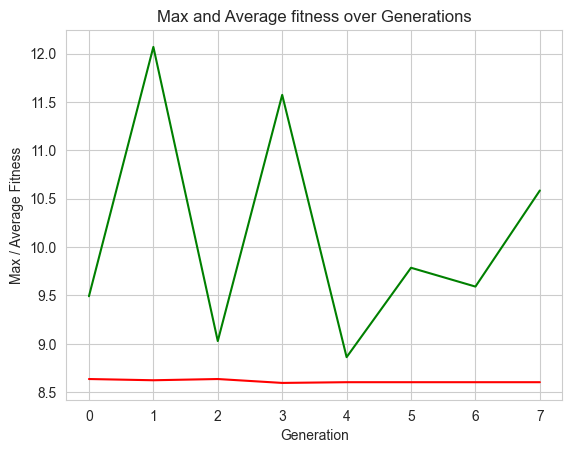

In [16]:
STRATEGIES = [LeftmostOutermostStrategy(), RightmostInnermostStrategy(), LeftmostInnermostStrategy(),
              RightmostOutermostStrategy(), RandomStrategy()]

BOUNDS_LOW = [0.1, 0.0, 0.0, 0.0]
BOUNDS_HIGH = [1.0, 1.0, 1.0, 1.0, ]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

# Genetic Algorithm constants:
POPULATION_SIZE = 20
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.3  # probability for mutating an individual
MAX_GENERATIONS = 7
HALL_OF_FAME_SIZE = 4
CROWDING_FACTOR = 10  # crowding factor for crossover and mutation

toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

# define the hyperparameter attributes individually:
for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i), random.uniform, BOUNDS_LOW[i], BOUNDS_HIGH[i])

# create a tuple containing an attribute generator for each param searched:
hyperparameters = ()
for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)


# create the individual operator to fill up an Individual instance:
def individual_creator() -> creator.Individual:
    indv = [0 for _ in range(NUM_OF_PARAMS)]
    for i in range(NUM_OF_PARAMS):
        indv[i] = random.uniform(BOUNDS_LOW[i], 1 - sum(indv))
    return creator.Individual(indv)


# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, individual_creator)


# fitness calculation
def fitness(individual):
    p = individual.copy()
    p.append(max(0, 1 - sum(individual)))
    steps = [sum([term.normalize(MixedStrategy(STRATEGIES, p))[1] for i in
                  range(RANDOM_AVERAGE_COUNT)]) / RANDOM_AVERAGE_COUNT for term in terms]
    steps = list(filter(lambda x: x != float('inf'), steps))

    distributions = get_common_distributions()
    distributions.remove('expon')
    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()

    mu, sigma = f_ln.fitted_param["norm"]
    result = np.e ** (mu + (sigma ** 2) / 2)
    print("expected number of steps to normalize using Mixed strategy= {}".format(result))
    if 1 - sum(individual) < 0:
        result += 100 * (sum(individual) - 1)
    return result,


toolbox.register("evaluate", fitness)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUNDS_LOW, up=BOUNDS_HIGH, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUNDS_LOW, up=BOUNDS_HIGH, eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = eaSimpleWithElitism(population,
                                          toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)

# print best solution found:
print("- Best solution is: ")
print("p = ", hof.items[0])

# extract statistics:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")
# plot statistics:
sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average fitness over Generations')
plt.show()

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 30.41it/s]


number of not normalized terms: 0
          sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm          0.003236  1731.196258 -1020.036878     inf      0.086043   
chi2             0.015276  1306.123639  -864.850722     inf      0.304187   
exponpow         0.018266  1221.560825  -846.975580     inf      0.372631   
powerlaw         0.023726  1129.948239  -820.817787     inf      0.470424   
rayleigh         0.027056  3085.336770  -812.291820     inf      0.356695   

             ks_pvalue  
lognorm   4.257889e-01  
chi2      1.043169e-08  
exponpow  5.678629e-13  
powerlaw  8.028044e-21  
rayleigh  6.812214e-12  
{'lognorm': {'s': 1.0321748390831726, 'loc': 0.579878850898445, 'scale': 4.918073770889984}}
Norm distribution: (9.8905, 19.20860965166402)


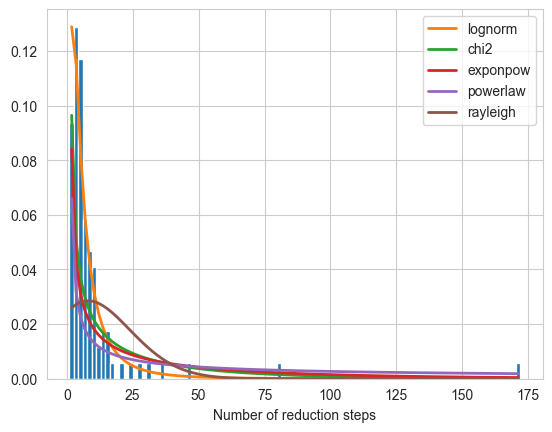

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 34.03it/s]

Log Norm distribution params: (1.7575481825951145, 0.8914382092105445); expected value = 8.626848191334506


In [17]:
p = hof.items[0]
p.append(max(0, 1 - sum(p)))
MixedStrategySteps = [
    sum([term.normalize(MixedStrategy(STRATEGIES, p))[1] for i in range(RANDOM_AVERAGE_COUNT)]) / RANDOM_AVERAGE_COUNT
    for term in terms]
draw_hist(MixedStrategySteps)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 29.41it/s]


number of not normalized terms: 0
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.004115  1720.288024 -996.020223     inf      0.089020   
exponpow         0.018377  1216.555665 -846.368076     inf      0.368449   
chi2             0.019853  1263.795939 -838.641848     inf      0.460723   
powerlaw         0.023925  1125.271401 -819.985956     inf      0.463328   
rayleigh         0.027238  3041.287472 -811.621057     inf      0.352833   

             ks_pvalue  
lognorm   3.838634e-01  
exponpow  1.102994e-12  
chi2      6.059758e-20  
powerlaw  3.540046e-20  
rayleigh  1.221174e-11  
{'lognorm': {'s': 1.024164848923578, 'loc': 0.5375992004547662, 'scale': 4.928763903421135}}
Norm distribution: (9.781500000000001, 18.785245080913903)


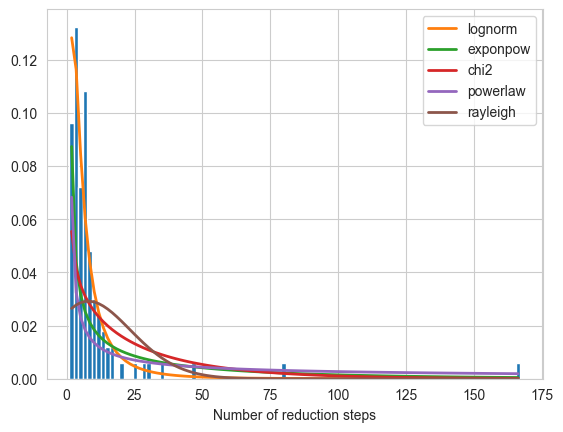

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 33.46it/s]

Log Norm distribution params: (1.748186806013544, 0.892898546160287); expected value = 8.5576080088163


In [18]:
p = [0.98, 0.005, 0.005, 0.005, 0.005]
steps = [
    sum([term.normalize(MixedStrategy(STRATEGIES, p))[1] for i in range(RANDOM_AVERAGE_COUNT)]) / RANDOM_AVERAGE_COUNT
    for term in terms]
draw_hist(steps)

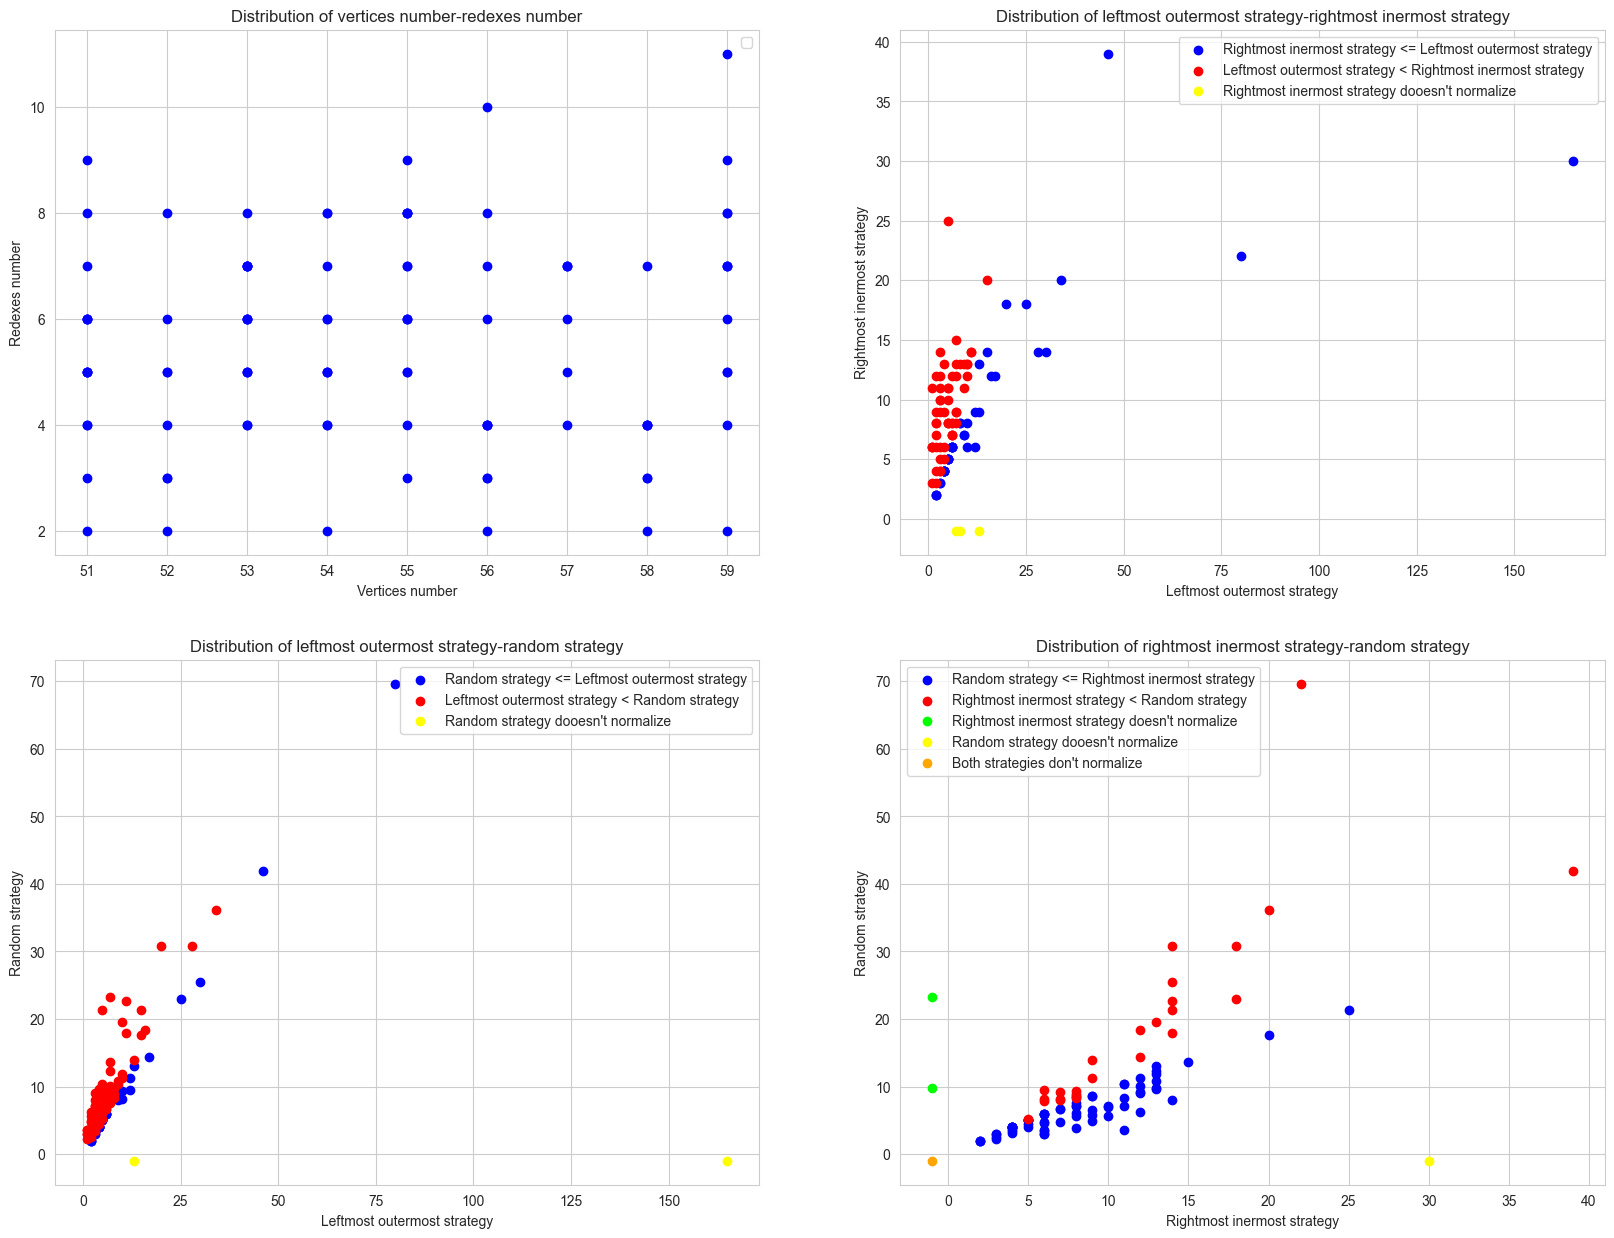

In [19]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
ax0, ax1, ax2, ax3 = axes.flatten()
draw_2d_distribution(ax0, countVertices, countRedexes, 'Vertices number', 'Redexes number')
draw_2d_strategy_distribution(ax1, stepsLO, stepsRI, 'Leftmost outermost strategy', 'Rightmost inermost strategy')
draw_2d_strategy_distribution(ax2, stepsLO, stepsRand, 'Leftmost outermost strategy', 'Random strategy')
draw_2d_strategy_distribution(ax3, stepsRI, stepsRand, 'Rightmost inermost strategy', 'Random strategy')
plt.show()

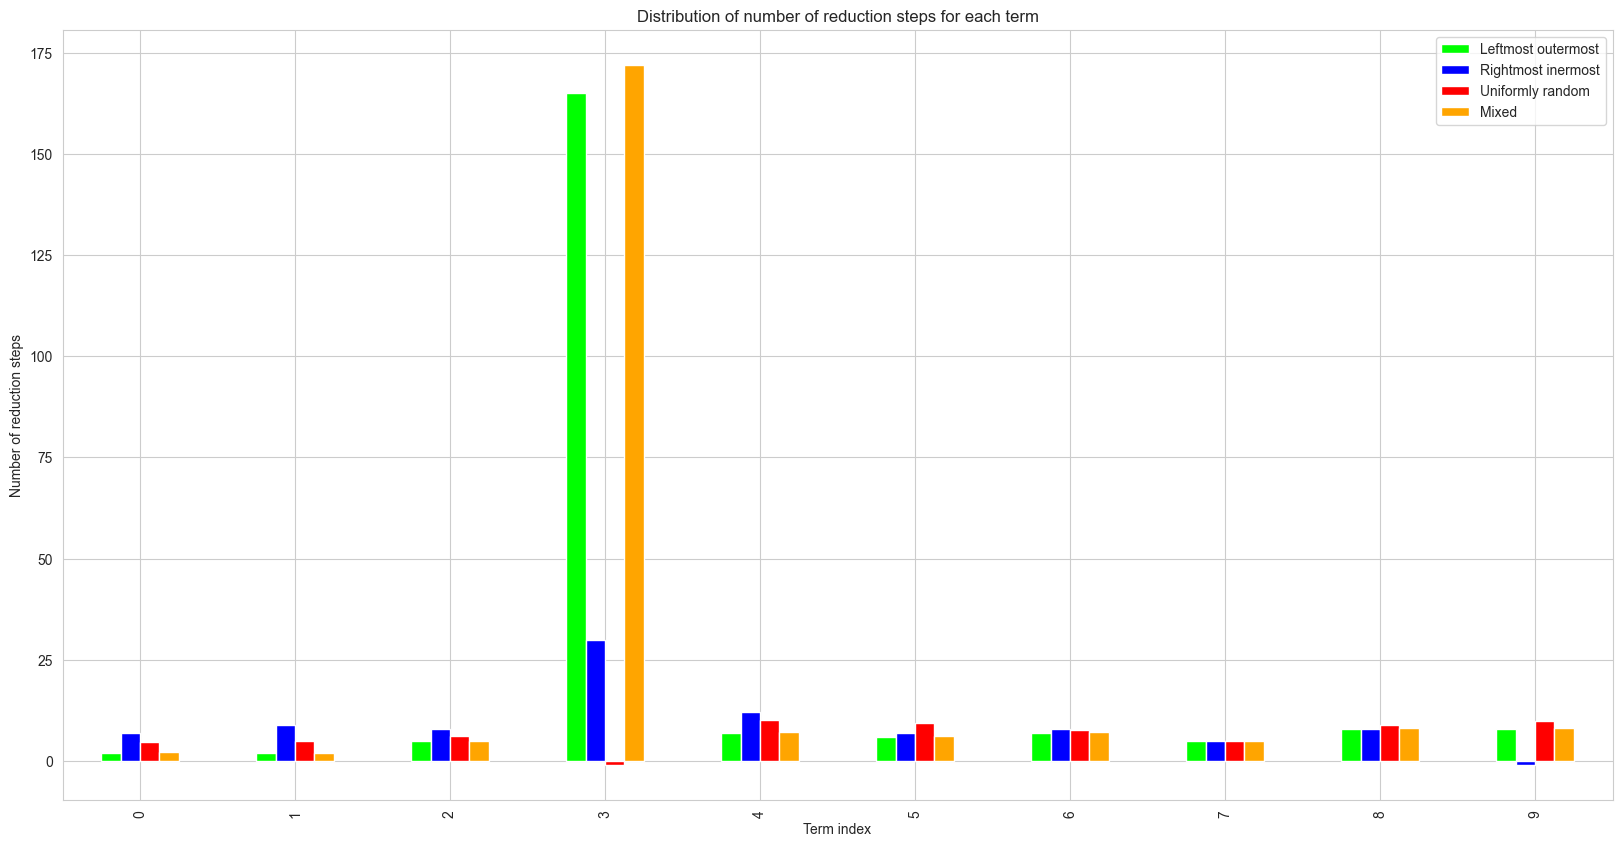

<AxesSubplot: title={'center': 'Distribution of number of reduction steps for each term'}, xlabel='Term index', ylabel='Number of reduction steps'>

In [20]:
colors = ['lime', 'blue', 'red', 'orange']
labels = ['Leftmost outermost', 'Rightmost inermost', 'Uniformly random', 'Mixed']
n = 20
draw_plot(stepsLO[10:n], stepsRI[10:n], stepsRand[10:n], MixedStrategySteps[10:n], labels, colors)

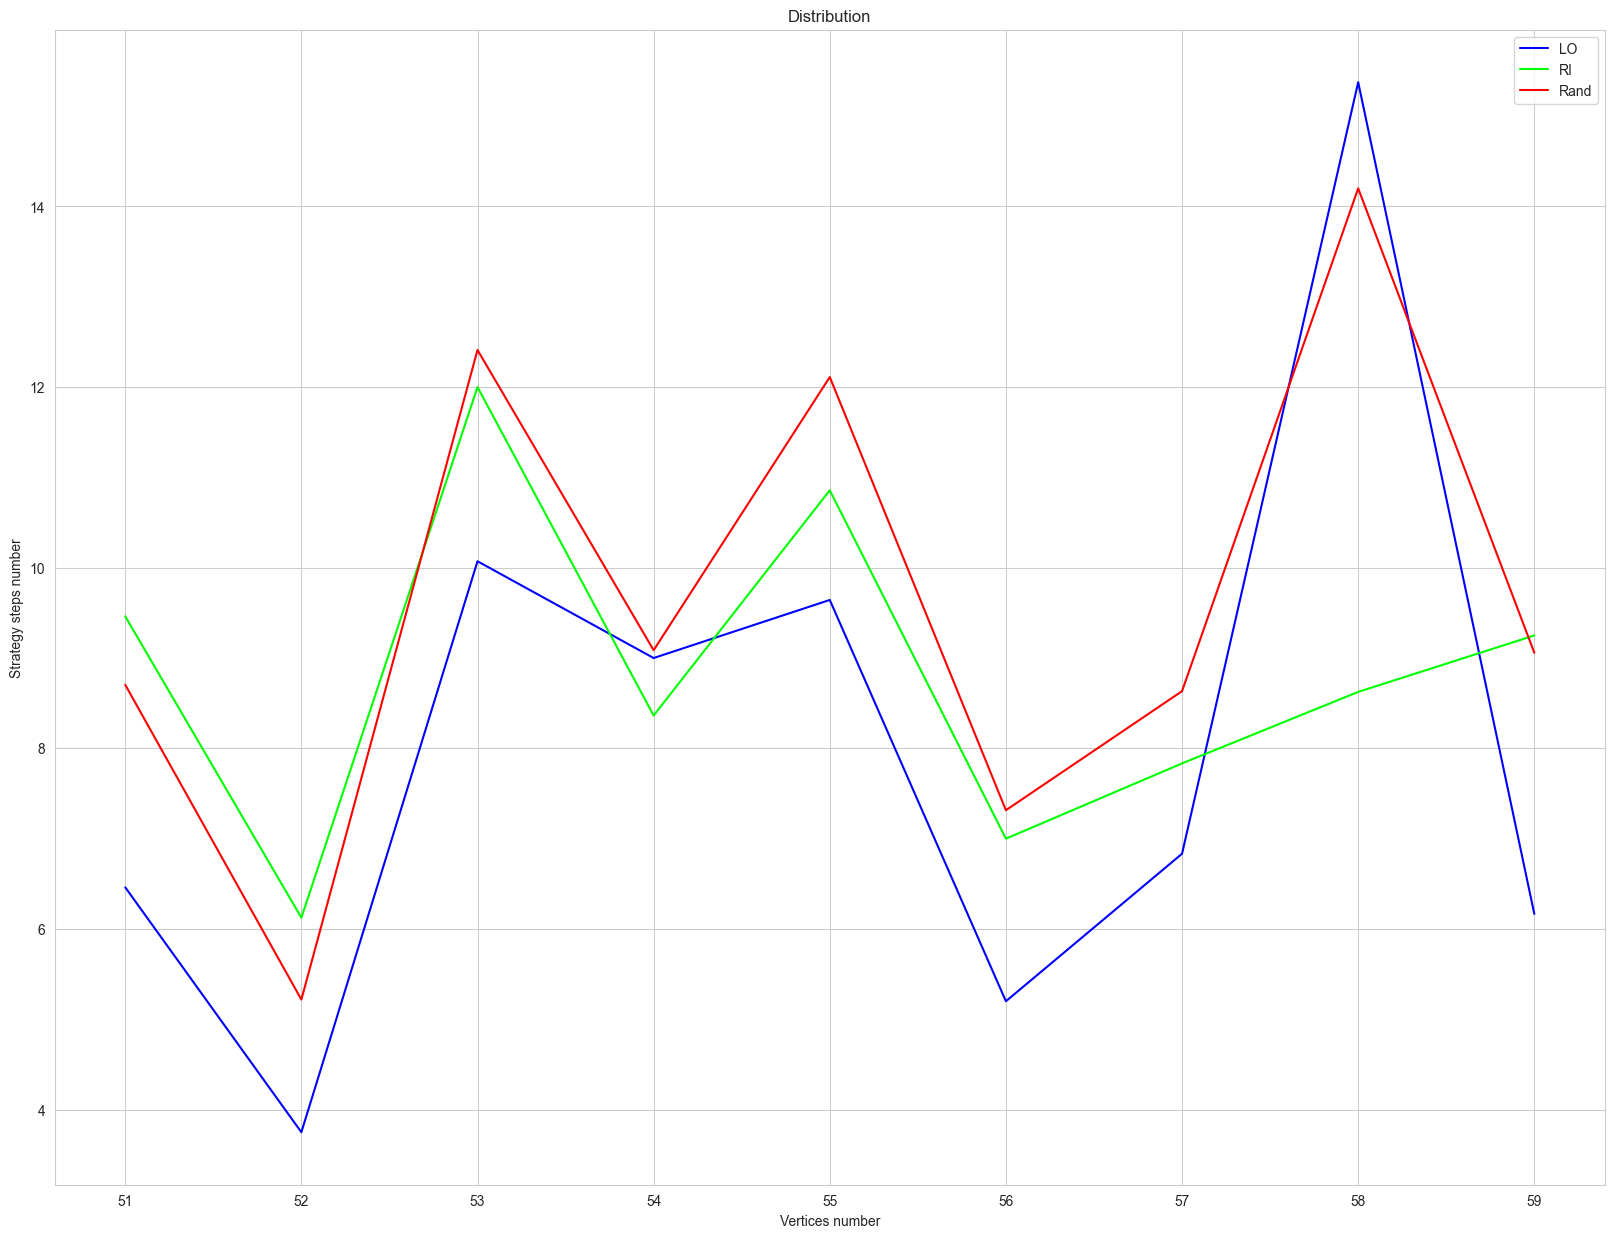

In [21]:
terms_dict = {i: [] for i in range(DOWNLIMIT, UPLIMIT)}

for i, term in enumerate(terms):
    terms_dict[term.verticesNumber].append((term, {'LO': stepsLO[i], 'RI': stepsRI[i], 'Rand': stepsRand[i]}))

average_term_data = dict()
for verticesNumber, data in terms_dict.items():
    data_without_inf = [d[1] for d in data if
                        d[1]['LO'] != float('inf') and d[1]['RI'] != float('inf') and d[1]['Rand'] != float('inf')]
    avgLO, avgRI, avgRand = 0, 0, 0
    for d in data_without_inf:
        avgLO += d['LO']
        avgRI += d['RI']
        avgRand += d['Rand']

    count = len(data_without_inf)
    if count != 0:
        average_term_data[verticesNumber] = {'LO': avgLO / count, 'RI': avgRI / count, 'Rand': avgRand / count}

plt.figure(figsize=(20, 15))
ax = plt.gca()
ax.plot(list(average_term_data.keys()), [data['LO'] for i, data in average_term_data.items()], color='blue', label='LO')
ax.plot(list(average_term_data.keys()), [data['RI'] for i, data in average_term_data.items()], color='lime', label='RI')
ax.plot(list(average_term_data.keys()), [data['Rand'] for i, data in average_term_data.items()], color='red',
        label='Rand')
ax.set(title='Distribution',
       xlabel='Vertices number',
       ylabel='Strategy steps number')
ax.legend(prop={'size': 10})

plt.show()

## TESTS

In [22]:
x, y, z = Var(), Var(), Var()
X, Z = Atom(x), Atom(z)
XXX = Application(Application(X, X), X)
XZ = Application(X, Z)
T = Application(Abstraction(x, XXX),
                Abstraction(x, Application(Abstraction(y, Z),
                                           XZ
                                           ))
                )

print(T)
for var, item in T._vars.items():
    print("\t{}".format(var), end=": ")
    print(item)

((fun v[5474301] => ((v[5474301] v[5474301]) v[5474301])) (fun v[5474301] => ((fun v[5474302] => v[5474303]) (v[5474301] v[5474303]))))
	v[5474301]: {'free': 0, 'bound': 4}
	v[5474303]: {'free': 2, 'bound': 0}


In [23]:
x, y, z, w, v = Var(), Var(), Var(), Var(), Var()
# (λx.(λy.( ((λz.(y z)) ((λw.w) x)) v )))
lambdaTerm = Abstraction(x,
                         Abstraction(y,
                                     Application(
                                         Application(
                                             Abstraction(z, Application(Atom(y), Atom(z))),
                                             Application(Abstraction(w, Atom(w)), Atom(w))),
                                         Atom(v))))


def testTerm():
    assert (len(lambdaTerm.redexes) == 2)
    assert (lambdaTerm.verticesNumber == 13)

    subterm = Application(Atom(y), Atom(z))
    assert (lambdaTerm.subterm(1) == lambdaTerm)
    assert (lambdaTerm.subterm(6) == subterm)
    assert (lambdaTerm.setSubterm(1, subterm) == subterm)

    assert (lambdaTerm._updateBoundVariables().verticesNumber == lambdaTerm.verticesNumber)
    assert (len(lambdaTerm._updateBoundVariables().redexes) == len(lambdaTerm.redexes))

    strategy = LeftmostOutermostStrategy()
    assert (len(lambdaTerm._betaConversion(strategy).redexes) == 1)
    assert (lambdaTerm._betaConversion(strategy).verticesNumber == 10)

    assert (len(lambdaTerm.normalize(strategy)[0].redexes) == 0)
    assert (lambdaTerm.normalize(strategy)[1] == 2)


def testStrategy():
    strategy = LeftmostOutermostStrategy()
    assert (strategy.redexIndex(lambdaTerm) == 4)


testTerm()
testStrategy()

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 30.46it/s]


number of not normalized terms: 0
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.027340  1343.772038 -797.471978     inf      0.083554   
exponpow         0.058632  1073.663338 -721.941777     inf      0.262945   
rayleigh         0.061836  2120.777485 -721.270221     inf      0.278362   
chi2             0.064805  1276.836768 -712.032853     inf      0.235364   
norm             0.072967  2161.894789 -704.883838     inf      0.246177   

             ks_pvalue  
lognorm   4.690152e-01  
exponpow  1.573827e-06  
rayleigh  2.827796e-07  
chi2      2.623099e-05  
norm      9.052730e-06  
{'lognorm': {'s': 0.9130926748464098, 'loc': 0.3616177980287508, 'scale': 4.998216000318369}}
Norm distribution: (8.151515151515152, 10.18551520182156)


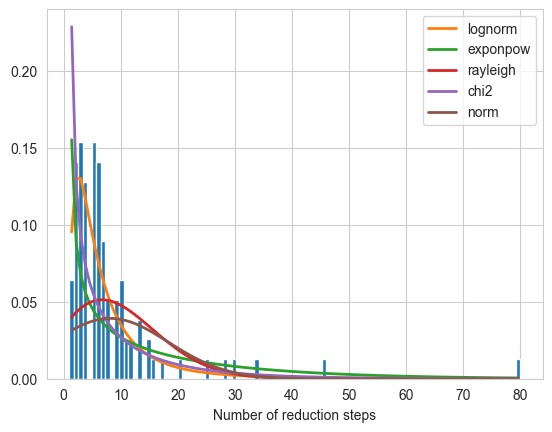

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 28.57it/s]

Log Norm distribution params: (1.708099728167793, 0.8314238425915178); expected value = 7.796949217175001


In [24]:
stepsLOWithoutTail = [x for x in stepsLO if x < 150]
draw_hist(stepsLOWithoutTail)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 29.73it/s]


number of not normalized terms: 0
          sumsquare_error          aic         bic  kl_div  ks_statistic  \
lognorm          0.027340  1343.772038 -797.471978     inf      0.083554   
exponpow         0.058632  1073.663338 -721.941777     inf      0.262945   
rayleigh         0.061836  2120.777485 -721.270221     inf      0.278362   
chi2             0.064805  1276.836768 -712.032853     inf      0.235364   
norm             0.072967  2161.894789 -704.883838     inf      0.246177   

             ks_pvalue  
lognorm   4.690152e-01  
exponpow  1.573827e-06  
rayleigh  2.827796e-07  
chi2      2.623099e-05  
norm      9.052730e-06  
{'lognorm': {'s': 0.9130926748464098, 'loc': 0.3616177980287508, 'scale': 4.998216000318369}}
Norm distribution: (8.151515151515152, 10.18551520182156)


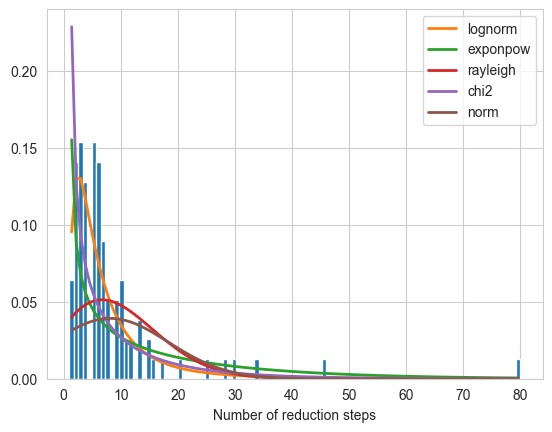

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 28.36it/s]

Log Norm distribution params: (1.708099728167793, 0.8314238425915178); expected value = 7.796949217175001


In [25]:
stepsLOWithoutTail = [x for x in stepsLO if x < 150]
draw_hist(stepsLOWithoutTail)